In [12]:
import numpy as np
import tensorflow as tf
import keras as k
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    make_scorer
)
from scikitplot.metrics import plot_roc

In [13]:

def decode_y(y_enc, enc_dict):
    return [enc_dict[y] for y in y_enc]

def load_dataset(path:str, squeeze=False):
    with open(path, 'rb') as f:
        d = np.load(f, allow_pickle=True)
        X_train = d['X_train']
        y_train = d['y_train']
        X_test = d['X_test']
        y_test = d['y_test']
        enc_vect = d['enc_dict']
        enc_dict = {i:class_ for class_ ,i in zip(enc_vect, range(enc_vect.shape[0]))}

    if squeeze:
        X_train = np.squeeze(X_train)
        X_test = np.squeeze(X_test)

    return (X_train,y_train,X_test,y_test,enc_dict)

In [4]:
X_train_raw, y_train_raw, X_test, y_test, encdict = load_dataset('../dataset_tab/tracks_processed.npz')

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X_train_raw, y_train_raw, test_size=0.1, stratify=y_train_raw, random_state=8)

## Il Modello

In [9]:
class MLP(k.Model):
  def __init__(self):
    super().__init__()

    self.dense1 = l.Dense(128, activation='relu', kernel_regularizer=k.regularizers.l2(0.05))
    self.batchnorm1 = l.BatchNormalization(axis=-1)

    self.dense2 = l.Dense(256, activation='relu', kernel_regularizer=k.regularizers.l2(0.08))
    self.batchnorm2 = l.BatchNormalization(axis=-1)

    self.dense3 = l.Dense(512, activation='relu', kernel_regularizer=k.regularizers.l2(0.1))
    self.batchnorm3 = l.BatchNormalization(axis=-1)

    self.dense4 = l.Dense(256, activation='relu', kernel_regularizer=k.regularizers.l2(0.08))
    self.batchnorm4 = l.BatchNormalization(axis=-1)

    self.out = l.Dense(114, activation='softmax', kernel_regularizer=k.regularizers.l2(0.05))

    self.drop = l.Dropout(0.5)

  def call(self, x):
    # layer 1
    x = self.dense1(x)
    x = self.batchnorm1(x)
    self.drop(x)

    x1 = tf.identity(x) 

    # layer 2
    x = self.dense2(x)
    x = self.batchnorm2(x)
    self.drop(x)

    x2 = tf.identity(x)

    # layer 3
    x = tf.concat([x, x1], axis=1) # residual connection concat
    x = self.dense3(x)
    x = self.batchnorm3(x)
    self.drop(x)


    # layer 4
    x = tf.concat([x, x2], axis=1) # residual connection concat
    x = self.dense4(x)
    x = self.batchnorm4(x)
    self.drop(x)




    # layer out
    x = x + x2 # residual connection somma
    x = self.out(x)

    return x

lo carico già addestrato

In [10]:
model = tf.saved_model.load('genre_clas_mod2')

## Training Plots

In [20]:
train_acc = np.load('logs2.npz')['tot_acc']
train_loss = np.load('logs2.npz')['tot_train_loss']
val_acc = np.load('logs2.npz')['tot_val_acc']
val_loss = np.load('logs2.npz')['tot_val_loss']

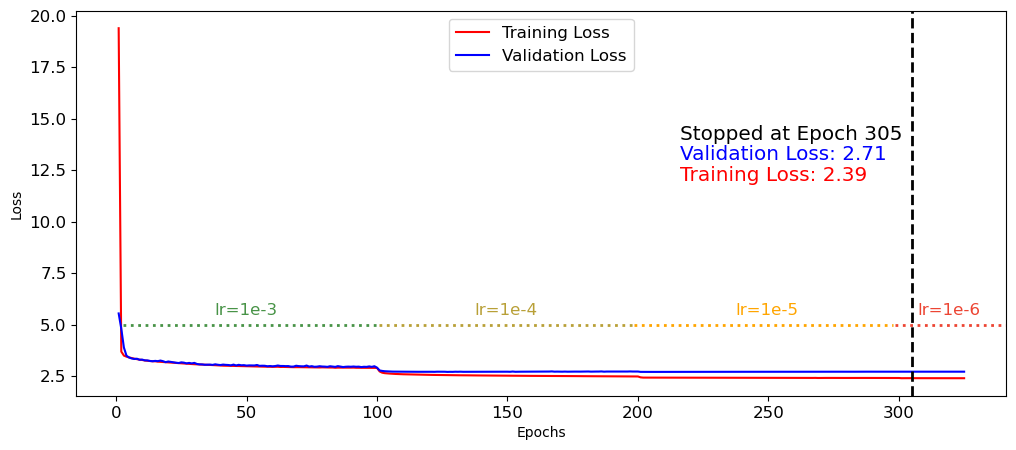

In [105]:
epochs = range(1, len(val_acc)+1)

plt.figure(figsize=(12,5))
plt.plot(epochs, train_loss, label='Training Loss', c='red')
plt.plot(epochs, val_loss, label='Validation Loss', c='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(fontsize='large')
plt.axvline(x=np.argmax(val_acc)+1, c='black', linestyle='--', linewidth=2)

plt.axhline(y=5, xmin=0.05, xmax=0.325,c='#026a00b8', linestyle=':', linewidth=2)
plt.axhline(y=5, xmin=0.325, xmax=0.6,c='#a78805cc', linestyle=':', linewidth=2)
plt.axhline(y=5, xmin=0.6, xmax=0.878,c='orange', linestyle=':', linewidth=2)
plt.axhline(y=5, xmin=0.88, xmax=1,c='#e81700cc', linestyle=':', linewidth=2)
plt.text(x=37.5, y=5.5, s=f'lr=1e-3', fontsize='large', c='#026a00b8')
plt.text(x=137.5, y=5.5, s=f'lr=1e-4', fontsize='large', c='#a78805cc')
plt.text(x=237.5, y=5.5, s=f'lr=1e-5', fontsize='large', c='orange')
plt.text(x=307, y=5.5, s=f'lr=1e-6', fontsize='large', c='#e81700cc')

plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=10)

plt.text(x=np.argmax(val_acc)-88, y=14, s=f'Stopped at Epoch {np.argmax(val_acc)+1}', fontsize='x-large')
plt.text(x=np.argmax(val_acc)-88, y=13, s=f'Validation Loss: {round(val_loss[np.argmax(val_acc)], 2)}', c='blue', fontsize='x-large')
plt.text(x=np.argmax(val_acc)-88, y=12, s=f'Training Loss: {round(train_loss[np.argmax(val_acc)], 2)}', c='red', fontsize='x-large')
plt.show()

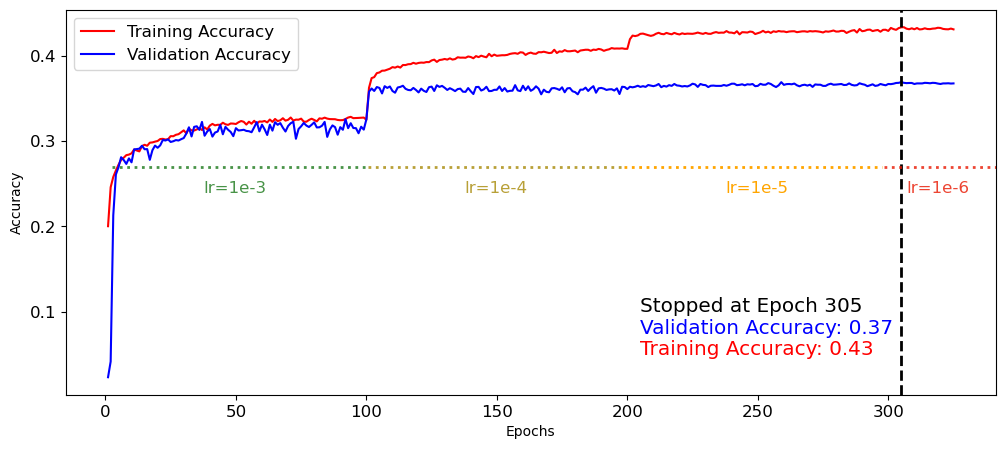

In [106]:
plt.figure(figsize=(12,5))
plt.plot(epochs, train_acc, label='Training Accuracy', c='red')
plt.plot(epochs, val_acc, label='Validation Accuracy', c='blue')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(fontsize='large')
plt.axvline(x=np.argmax(val_acc)+1, c='black', linestyle='--', linewidth=2)


plt.axhline(y=0.27, xmin=0.05, xmax=0.325,c='#026a00b8', linestyle=':', linewidth=2)
plt.axhline(y=0.27, xmin=0.325, xmax=0.6,c='#a78805cc', linestyle=':', linewidth=2)
plt.axhline(y=0.27, xmin=0.6, xmax=0.878,c='orange', linestyle=':', linewidth=2)
plt.axhline(y=0.27, xmin=0.88, xmax=1,c='#e81700cc', linestyle=':', linewidth=2)
plt.text(x=37.5, y=0.24, s=f'lr=1e-3', fontsize='large', c='#026a00b8')
plt.text(x=137.5, y=0.24, s=f'lr=1e-4', fontsize='large', c='#a78805cc')
plt.text(x=237.5, y=0.24, s=f'lr=1e-5', fontsize='large', c='orange')
plt.text(x=307, y=0.24,s=f'lr=1e-6', fontsize='large', c='#e81700cc')

plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=10)

plt.text(x=np.argmax(val_acc)-99, y=0.1, s=f'Stopped at Epoch {np.argmax(val_acc)+1}', fontsize='x-large')
plt.text(x=np.argmax(val_acc)-99, y=0.075, s=f'Validation Accuracy: {round(val_acc[np.argmax(val_acc)], 2)}', c='blue', fontsize='x-large')
plt.text(x=np.argmax(val_acc)-99, y=0.05, s=f'Training Accuracy: {round(train_acc[np.argmax(val_acc)], 2)}', c='red', fontsize='x-large')
plt.show()

## Roc Curves

In [123]:
y_pred_test_prob = model.serve(X_test).numpy()
y_pred_test = np.argmax(y_pred_test_prob, axis=1)

In [125]:
def top_flop_f1(y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    l = [(key, val['f1-score']) for key,val in report.items() if (isinstance(val, dict) and key not in ['macro avg', 'weighted avg'])]
    l.sort(key= lambda x: x[1], reverse=True)
    top5 = l[:5]
    l.sort(key= lambda x: x[1], reverse=False)
    flop5 = l[:5]

    print('TOP 5 F1-SCORE:')
    for top in top5:
        print(f'{top[0]}: {top[1]}')

    print('\n\nFLOP 5 F1-SCORE:')
    for flop in flop5:
        print(f'{flop[0]}: {flop[1]}')

top_flop_f1(decode_y(y_test, encdict), decode_y(y_pred_test, encdict))

TOP 5 F1-SCORE:
comedy: 0.8355555555555556
grindcore: 0.7664473684210527
sleep: 0.7396061269146609
honky-tonk: 0.73
study: 0.7294469357249627


FLOP 5 F1-SCORE:
alt-rock: 0.0
edm: 0.0
indie: 0.0
punk: 0.0
singer-songwriter: 0.0


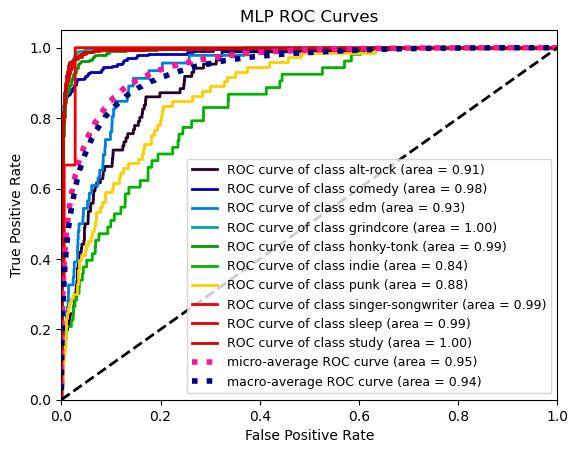

In [127]:



plot_roc(decode_y(y_test, encdict), y_pred_test_prob, classes_to_plot=['comedy', 'grindcore', 'sleep', 'honky-tonk', 'study', 
                                                                                        'alt-rock', 'edm', 'indie', 'punk', 'singer-songwriter'])
plt.legend(loc='lower right',prop={'size': 9})
plt.title('MLP ROC Curves')
plt.show()

## Test

In [121]:
y_pred= np.argmax(model.serve(X_test).numpy(), axis= 1)

In [122]:
print(classification_report(decode_y(y_test, encdict), decode_y(y_pred, encdict), zero_division=0))

                   precision    recall  f1-score   support

         acoustic       0.19      0.22      0.21       267
         afrobeat       0.31      0.33      0.32       294
         alt-rock       0.00      0.00      0.00        86
      alternative       0.14      0.10      0.12       154
          ambient       0.35      0.34      0.34       252
            anime       0.22      0.20      0.21       216
      black-metal       0.51      0.53      0.52       290
        bluegrass       0.41      0.52      0.46       294
            blues       0.20      0.05      0.08       177
           brazil       0.26      0.22      0.24       234
        breakbeat       0.36      0.31      0.33       289
          british       0.13      0.02      0.04       170
         cantopop       0.28      0.32      0.30       261
    chicago-house       0.45      0.52      0.48       293
         children       0.38      0.41      0.40       280
            chill       0.17      0.14      0.15       